In [ ]:
#Initialisation du google drive
from google.colab import drive
drive.mount('/gdrive')

#Lien: https://drive.google.com/drive/folders/1vkE4PW2dqjFF7_bn3R2VIvI6covY3xkh?usp=sharing

Mounted at /gdrive


In [ ]:
import os
os.listdir()
# #os.mkdir('segmented')
# #os.listdir()

# import shutil
# src = '/gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/segmented'
# dst='~/segmented'
# shutil.copytree(src, dst)

['.config', 'sample_data']

In [ ]:
# os.remove('kaggle (1).json')
# os.remove('kaggle.json')

# 1.0.Telechargement et décompression du dataset sélectionné

In [ ]:
#install Kaggle
!pip install -q kaggle

from google.colab import files
files.upload()


#create kaggle folder
!mkdir ~/.kaggle

#copy kaggle.jason ~/.kaggle
! cp kaggle.json ~/.kaggle

#permission for json to act
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download abdallahalidev/plantvillage-dataset
!unzip plantvillage-dataset.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.G

#2.Import des packages

In [ ]:
#Librairies communes
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Autres librairies communes utiles au projet
import time, cv2
import os
import glob, cv2
import random
import tensorflow as tf

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#tensorflox
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D,Conv2D,MaxPooling2D,AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Model,Input,callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

#keras
from keras.preprocessing import image


#3.Preprocessing



### Initialisation des chemins et des classes

In [ ]:
#Initialisation des chemins pour aller chercher les images dans le google drive
#chemin_image = '/gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/color'
chemin_image = 'plantvillage dataset/color'
chemin_image_segmented = 'plantvillage dataset/segmented'
chemin_image_fond = '/gdrive/MyDrive/epyphyte/donnees/photos_reelles/Fonds'
chemin_image_test = '/gdrive/MyDrive/epyphyte/donnees/test'  # 53 photos réelles
chemin_image_test2 = '/gdrive/MyDrive/epyphyte/donnees/test2' # 53 photos color
chemin_image_test3 = '/gdrive/MyDrive/epyphyte/donnees/test3' # 53 photos segmented


# enregistrement
version = 'bisortie_modele_plantes_dependantes_261221_#0'
checkpoint_filepath = '/gdrive/MyDrive/epyphyte/entrainement/checkpoints/'+version
save_folder='/gdrive/MyDrive/epyphyte/entrainement/modeles/'+version

path_segmented='/gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/segmented'
path_color='/gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/color'
path_fond='/gdrive/MyDrive/epyphyte/donnees/photos_reelles/Fonds/Fond_01.jpg'

#Paramètres de modélisation               
largeur = 224
hauteur = 224
profondeur = 3
EPOCHS = 30
batch_size = 32

#Dictionnaires liens numéros <> classes
df = pd.read_csv('/gdrive/MyDrive/epyphyte/donnees/info_maladie.csv', sep=';')


def dataframe_to_dictionnary(dataframe, cle, valeur):
  # Renvoie un dictionnaire à partir de 2 colonnes d'un dataframe
  df_temp = dataframe[[cle, valeur]].set_index(cle)
  return df_temp[valeur].to_dict()

CLASSES = dataframe_to_dictionnary(df, 'dossier', 'classe')
reversed_classes = dataframe_to_dictionnary(df, 'classe', 'dossier')

nb_classes = len(CLASSES)
#print("Le nombre de classes est: ",nb_classes)

In [ ]:
#transformation de la lecture du repertoire chemin_segmented en une fonction


def repertoire_to_df(chemin):


  #Construction du DataFrame avec le chemin des images et les catégories
  df_chemin = pd.DataFrame()
  #for (repertoire, sousRepertoires, fichiers) in os.walk(path_segmented):
  for (repertoire, sousRepertoires, fichiers) in os.walk(chemin):
      df_temp = pd.DataFrame(data=fichiers, columns=['fichier'])
      df_temp['dossier'] = repertoire
      df_chemin = pd.concat([df_chemin, df_temp], axis = 0)

  df_chemin['chemin_segmented'] = df_chemin['dossier'] +'/'+ df_chemin['fichier']
  #print(df_chemin.iloc[0]['dossier'])
  #print(df_chemin.iloc[0]['fichier'])
  #print(df_chemin.iloc[0]['chemin_segmented'])
  df_chemin['dossier']=df_chemin['dossier'].apply(lambda x: x[31:])

  df_chemin['plante_maladie']=df_chemin['dossier'].apply(lambda x: x.split('/')[0])
  df_chemin['plante']=df_chemin['plante_maladie'].apply(lambda x: x.split('___')[0])
  df_chemin['maladie']=df_chemin['plante_maladie'].apply(lambda x: x.split('___')[1])

  df_chemin = df_chemin.drop('dossier', axis=1)
  df_chemin = df_chemin.drop('fichier', axis=1)

  df_chemin['chemin_color']=df_chemin['chemin_segmented'].apply(lambda x: x.replace("segmented","color",1))
  df_chemin['chemin_color']=df_chemin['chemin_color'].apply(lambda x: x.replace("_final_masked","",1))
  df_chemin['chemin_color']=df_chemin['chemin_color'].apply(lambda x: x.replace("jpg","JPG",1))

  return df_chemin

df_chemin=repertoire_to_df(chemin_image_segmented)

In [ ]:
def repertoire_test_to_df(chemin):


  #Construction du DataFrame avec le chemin des images et les catégories
  df_chemin = pd.DataFrame()
  #for (repertoire, sousRepertoires, fichiers) in os.walk(path_segmented):
  for (repertoire, sousRepertoires, fichiers) in os.walk(chemin):
      df_temp = pd.DataFrame(data=fichiers, columns=['fichier'])
      df_temp['dossier'] = repertoire
      df_chemin = pd.concat([df_chemin, df_temp], axis = 0)

  df_chemin['chemin_segmented'] = df_chemin['dossier'] +'/'+ df_chemin['fichier']

  df_chemin['dossier']=df_chemin['dossier'].apply(lambda x: x[15:])
  df_chemin['plante_maladie']=df_chemin['dossier'].apply(lambda x: x.split('/')[0])
  df_chemin['plante']=df_chemin['plante_maladie'].apply(lambda x: x.split('___')[0])
  df_chemin['maladie']=df_chemin['plante_maladie'].apply(lambda x: x.split('___')[1])

  df_chemin = df_chemin.drop('dossier', axis=1)
  df_chemin = df_chemin.drop('fichier', axis=1)

  return df_chemin

chemin_images_reelles = 'images_reelles'
emplacement_src_gdrive = '/gdrive/MyDrive/epyphyte/donnees/test'

import shutil
#if not os.path.isdir('chemin_images_relles'):
shutil.copytree(emplacement_src_gdrive,chemin_images_reelles)

df_chemin_test=repertoire_test_to_df(chemin_images_reelles)
df_chemin_test.head()

,chemin_segmented,plante_maladie,plante,maladie
0,images_reelles/Apple___Apple_scab/Pommier-Tave...,Apple___Apple_scab,Apple,Apple_scab
1,images_reelles/Apple___Apple_scab/Pommier-tave...,Apple___Apple_scab,Apple,Apple_scab
2,images_reelles/Apple___Apple_scab/Pommier-tave...,Apple___Apple_scab,Apple,Apple_scab
3,images_reelles/Apple___Apple_scab/Pommier-tave...,Apple___Apple_scab,Apple,Apple_scab
4,images_reelles/Apple___Apple_scab/Pommier-Tave...,Apple___Apple_scab,Apple,Apple_scab


In [ ]:
# Onehot encoding des deux etiquettes : non utiisé dans la suite -> tocategorical() dans la fct de generation des donnees
df_chemin_2=df_chemin
df_chemin_2=df_chemin_2.drop(['chemin_color'],axis=1)
A=pd.get_dummies(df_chemin_2['plante'])
B=pd.get_dummies(df_chemin_2['maladie'])
#df_chemin_2=pd.concat([df_chemin_2,A],axis=1)
#df_chemin_2=pd.concat([df_chemin_2,B],axis=1)


df_plante = pd.concat([df_chemin_2['plante'],A],axis=1)
df_maladie = pd.concat([df_chemin_2['maladie'],B],axis=1)
Nplantes = len(df_chemin_2['plante'].unique())
Nmaladies= len(df_chemin_2['maladie'].unique())

print('Nombre plante=',Nplantes)
print('Nombre maladie=',Nmaladies)
              


#df_chemin_2=df_chemin_2.drop(['plante','maladie'],axis=1)

df_chemin_2

Nombre plante= 14
Nombre maladie= 21


,chemin_segmented,plante_maladie,plante,maladie
0,"plantvillage dataset/segmented/Pepper,_bell___...","Pepper,_bell___Bacterial_spot","Pepper,_bell",Bacterial_spot
1,"plantvillage dataset/segmented/Pepper,_bell___...","Pepper,_bell___Bacterial_spot","Pepper,_bell",Bacterial_spot
2,"plantvillage dataset/segmented/Pepper,_bell___...","Pepper,_bell___Bacterial_spot","Pepper,_bell",Bacterial_spot
3,"plantvillage dataset/segmented/Pepper,_bell___...","Pepper,_bell___Bacterial_spot","Pepper,_bell",Bacterial_spot
4,"plantvillage dataset/segmented/Pepper,_bell___...","Pepper,_bell___Bacterial_spot","Pepper,_bell",Bacterial_spot
...,...,...,...,...
5502,plantvillage dataset/segmented/Orange___Haungl...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening)
5503,plantvillage dataset/segmented/Orange___Haungl...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening)
5504,plantvillage dataset/segmented/Orange___Haungl...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening)
5505,plantvillage dataset/segmented/Orange___Haungl...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening)


In [ ]:
liste_plante =  df_chemin_2['plante'].unique()
Nplantes = len(liste_plante)
liste_plante=pd.DataFrame(liste_plante)
liste_plante = pd.concat([liste_plante,pd.DataFrame(np.arange(Nplantes))],axis=1)
liste_plante.columns = ['plante','code_plante']

CLASSES_plantes = dataframe_to_dictionnary(liste_plante, 'plante', 'code_plante')
reversed_classes_plantes = dataframe_to_dictionnary(liste_plante, 'code_plante', 'plante')

liste_maladie =  df_chemin_2['maladie'].unique()
Nmaladies = len(liste_maladie)
liste_maladie=pd.DataFrame(liste_maladie)
liste_maladie = pd.concat([liste_maladie,pd.DataFrame(np.arange(Nmaladies))],axis=1)
liste_maladie.columns = ['maladie','code_maladie']

CLASSES_maladies = dataframe_to_dictionnary(liste_maladie, 'maladie', 'code_maladie')
reversed_classes_maladies = dataframe_to_dictionnary(liste_maladie, 'code_maladie', 'maladie')
df_chemin_3 = df_chemin_2

df_chemin_3.head()

def code_label(df):


  df['code_plante']=df['plante'].apply(lambda x : CLASSES_plantes[x])
  df['code_maladie']=df['maladie'].apply(lambda x : CLASSES_maladies[x])

  df['code_plante_maladie']=1000*df["code_plante"]+df['code_maladie']
  df['code_plante_maladie']=df['code_plante_maladie'].apply(lambda x : [x//1000,x%1000])
  df['code_plante_maladie_combine']=df['plante_maladie'].apply(lambda x : CLASSES[x])

  return df

df_chemin_3=code_label(df_chemin_3)
df_chemin_3=pd.concat([df_chemin_3,A],axis=1)
df_chemin_3=pd.concat([df_chemin_3,B],axis=1)


df_chemin_test = code_label(df_chemin_test)


In [ ]:
df_chemin_test.head()

,chemin_segmented,plante_maladie,plante,maladie,code_plante,code_maladie,code_plante_maladie,code_plante_maladie_combine
0,images_reelles/Apple___Apple_scab/Pommier-Tave...,Apple___Apple_scab,Apple,Apple_scab,5,13,"[5, 13]",0
1,images_reelles/Apple___Apple_scab/Pommier-tave...,Apple___Apple_scab,Apple,Apple_scab,5,13,"[5, 13]",0
2,images_reelles/Apple___Apple_scab/Pommier-tave...,Apple___Apple_scab,Apple,Apple_scab,5,13,"[5, 13]",0
3,images_reelles/Apple___Apple_scab/Pommier-tave...,Apple___Apple_scab,Apple,Apple_scab,5,13,"[5, 13]",0
4,images_reelles/Apple___Apple_scab/Pommier-Tave...,Apple___Apple_scab,Apple,Apple_scab,5,13,"[5, 13]",0


### Gestion des fonds

In [ ]:


liste_img_fond = []

#Recherche et chagement de la liste des images de fonds
for fichier in glob.glob(chemin_image_fond + '/**/*.*', recursive=True):
  img_fond = cv2.imread(fichier)
  #img_fond = cv2.cvtColor(img_fond, cv2.COLOR_BGR2RGB)
  img_fond = cv2.resize(img_fond, (largeur,hauteur))
  liste_img_fond.append(img_fond)

#Définition de la fonction de preprocessing pour remplacer les fonds noir par l'image de fond
def preprocess_input2(img):
  # img1= preprocess_input(img)
  # img1=(255*(img-img.min())/(img.max()-img.min()))
  # img1=img1.astype(int)

  if random.random()>0.5:
    img = np.fliplr(img)

  
  if random.random()>0.5:
    img = np.flipud(img)


  if random.random()>0.5:
    img = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)

  if random.random()>0.5:
    a=0.75+0.25*random.random()
    img_r = cv2.resize(img,(int(a*largeur),int(a*hauteur)))
    s=img_r.shape  
    img = np.zeros((224,224,3))
  
    x=int(random.random()*(224-s[0]-2))
    y=int(random.random()*(224-s[1]-2))
    #print(s,x,y)

    img[x:x+s[0],y:y+s[1],:]=img_r

  else :

    a= 1+random.random()
    img_r=cv2.resize(img,(int(a*largeur),int(a*hauteur)))
    s=img_r.shape 
    x=int(random.random()*(s[0]-224))
    y=int(random.random()*(s[1]-224))   
    img = img_r[x:x+224,y:y+224,:]


  G=img[:,:,1]
  G.shape=(224,224,1)
  G = np.tile(G,(1,1,3))
  # R=img1[:,:,0]
  # R.shape=(224,224,1)
  # R = np.tile(R,(1,1,3))
  # B=img1[:,:,2]
  # B.shape=(224,224,1)
  # B = np.tile(B,(1,1,3))

  fond = random.choice(liste_img_fond)
  m_fond= fond.mean(axis=(1,2))
  m_img = img.mean(axis=(1,2))


  masque = np.where((G<=10) , np.zeros(shape=(224,224,3)), np.ones(shape=(224,224,3)))
  kernel = np.ones((7,7),np.uint8)
  masque = cv2.erode(masque,kernel,iterations = 1)
  #img = np.where(masque==0, random.choice(liste_img_fond), img1)
  return preprocess_input(np.where(masque==0, np.zeros(shape=(224,224,3)), img))

In [ ]:
random.random()

0.7271976434225594

In [ ]:
# img_final = preprocess_input2(img_mod)
# plt.imshow(img_final)
# im = (img_final-img_final.min())/(img_final.max()-img_final.min())
# plt.imshow(im)
# print(im.shape)

###Visualisation des données

chemin color =  plantvillage dataset/color/Pepper,_bell___Bacterial_spot/23e657c9-1f08-4714-817b-48fd2f3e2cf3___JR_B.Spot 8962.JPG
chemin segmented =  plantvillage dataset/segmented/Pepper,_bell___Bacterial_spot/23e657c9-1f08-4714-817b-48fd2f3e2cf3___JR_B.Spot 8962_final_masked.jpg


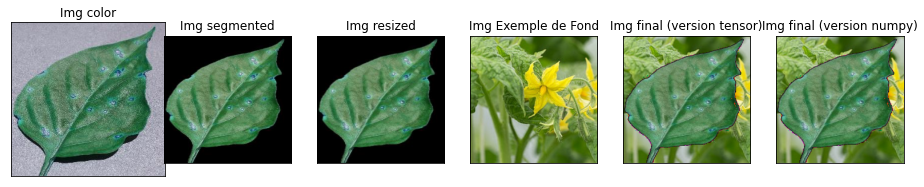

(256, 256, 3)


In [ ]:
#Visualisation de la segmentation
fig = plt.figure(figsize = (16,12))

rdm=random.randint(0,len(df))

#Affichage d'une image aléatoire
print("chemin color = ",df_chemin.iloc[rdm]['chemin_color'])
print("chemin segmented = ",df_chemin.iloc[rdm]['chemin_segmented'])
img_color = cv2.imread(df_chemin.iloc[rdm]['chemin_color'],cv2.IMREAD_COLOR)
img_segmented = cv2.imread(df_chemin.iloc[rdm]['chemin_segmented'], cv2.IMREAD_COLOR)
img_mod = cv2.resize(img_segmented, (largeur,hauteur))
img_fond = cv2.imread(path_fond,cv2.IMREAD_COLOR)
img_fond = cv2.cvtColor(img_fond, cv2.COLOR_BGR2RGB)
img_fond = cv2.resize(img_fond, (largeur,hauteur))
img_mod = cv2.resize(img_segmented, (largeur,hauteur))

fig.add_subplot(1,5,1)
plt.imshow(img_color)
plt.xticks([])
plt.yticks([])
plt.title('Img color')

fig.add_subplot(1,6,2)
plt.imshow(img_segmented)#cmap='gray'
plt.xticks([])
plt.yticks([])
plt.title('Img segmented')

fig.add_subplot(1,6,3)
plt.imshow(img_mod)#cmap='gray'
plt.xticks([])
plt.yticks([])
plt.title('Img resized')

fig.add_subplot(1,6,4)
plt.imshow(img_fond)
plt.xticks([])
plt.yticks([])
plt.title('Img Exemple de Fond')

#Utilisation de tf.where pour remplacer le fond noir de l'image segmenté
# attention ici ce sont des tensor (-> tensorflow), il faut utiliser np.where (bcp de methode np ont un equivalent tf)
tf_mod = tf.Variable(img_mod)
tf_fond = tf.Variable(img_fond)
tf_final = tf.where(tf_mod<10,tf_fond,tf_mod) 
img_final=np.where(img_mod<10,img_fond,img_mod) 
#img_final= preprocess_input2(img_mod)


fig.add_subplot(1,6,5)
plt.imshow(tf_final)
plt.xticks([])
plt.yticks([])
plt.title('Img final (version tensor)')

fig.add_subplot(1,6,6)
plt.imshow(img_final)
plt.xticks([])
plt.yticks([])
plt.title('Img final (version numpy)')


plt.show()

print(img_segmented.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


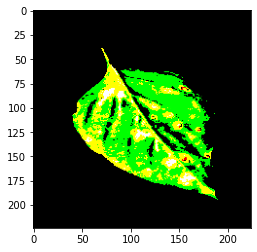

In [ ]:
img_final = preprocess_input2(img_mod)
plt.imshow(img_final)

Sur l'image finale, on peut constater un liseré autour de la feuille.

Ce liseré pourrait biaiser notre modèle.

#4.Data generator à deux sorties

In [ ]:
class DataGenerator():
    
    
  def __init__(self, df):
    self.df = df        
        

  def generate_splits(self,with_balancing = False):     
        
    '''reproduction de la fonction train_test_split''' 
                              
    permut = np.random.permutation(len(self.df))          # mélange des indices

    # équivalent de data_without_test, data_test = train_test_split(data, test_size=0.2)
    train_up_to = int(len(self.df)*0.8)
    indices_without_test = permut[:train_up_to]           
    test_indices = permut[train_up_to:]
    
        
    # équivalent de data_train, data_validation = train_test_split(data_without_test, test_size=0.2)
    train_up_to = int(train_up_to*0.8)
    train_indices = indices_without_test[:train_up_to]
    valid_indices = indices_without_test[train_up_to:] 

    if with_balancing :

      code_combine = 1000 *self.df.iloc[train_indices]["code_maladie"]+self.df.iloc[train_indices]['code_plante'];
      code_combine = code_combine.reset_index()
      code_combine.columns = ['indice_echantillon','code_combine']
      rebalance = code_combine['code_combine'].value_counts()
      rebalance = rebalance.iloc[0]/rebalance
      rebalance = rebalance.apply(lambda x: int(x))
            
      supplement_rebalance = []

      for i,indice_ in enumerate(train_indices):

        a= rebalance[code_combine.iloc[i]['code_combine']]     
        if a>1:     

          for j in range(a-1):

            supplement_rebalance.append(indice_)

      train_indices=np.concatenate([train_indices,np.asarray(supplement_rebalance)])


    return train_indices, valid_indices, test_indices     # on retourne les indices


  def generate_images(self, indices, is_training, batch_size=32, step_epoch = 1000000000):  
    '''utilisé pour générer des batchs avec des images lors de l'entraînement/test/validation de notre modèle Keras
    par exemple, on aura "indices=train_indices, is_training=True" pour un générateur d'entraînement
    "indices=test_indices, is_training=False" pour un générateur de test'''
    
    imgs, plante, maladie = [], [], []  # on initialise des listes vides pour contenir ce que renverra le générateur
                                              
    while True:

      nb_step=0

      for i in indices:
                
        echantillon, plante_1hot,maladie_1hot = self.preprocessing(i)
        imgs.append(echantillon)
        plante.append(plante_1hot)
        maladie.append(maladie_1hot)

        if len(imgs) >= batch_size:
                            
          nb_step +=1

          # dès qu'on a atteind la taille de batch souhaitée, on renvoie les données
          yield np.array(imgs), [np.array(plante),np.array(maladie)]  
          imgs, plante, maladie = [], [], [] 
                    
          # à la fin de l'epoch, permutation aléatoire des , pourpresenter des batchs différents à l'apprentissage pour l'epoch suivante
          if nb_step>= step_epoch:
            indices=np.random.permutation(indices)
            nb_step=0

        # pour les prédictions, il faut s'arrêter après avoir parcouru toutes les données une fois
      if not is_training:
        break


  def get_images(self,indices,sans_fond=False):
  #Cette méthode fournit les images de test et ses labels pour l'evaluation des performances en dehors de la boucle d'  apprentissage

    imgs, plante, maladie = [], [], []

    for i in indices:

      echantillon, plante_1hot,maladie_1hot = self.preprocessing(i,sans_fond)
      imgs.append(echantillon)
      plante.append(plante_1hot)
      maladie.append(maladie_1hot)

    return np.array(imgs),[np.array(plante),np.array(maladie)]

        


  def preprocessing(self,indice,sans_fond=False):


    # pretraitement sur l'image
    echantillon = cv2.imread(self.df.iloc[indice]['chemin_segmented'], cv2.IMREAD_COLOR)
    echantillon = cv2.cvtColor(echantillon, cv2.COLOR_BGR2RGB)
    echantillon = cv2.resize(echantillon, (largeur,hauteur))
    if not sans_fond:
      echantillon  = preprocess_input2(echantillon)/255
    else :
      echantillon  = preprocess_input(echantillon)/255
      

    #labels de l'image correspondante                             
    plante_1hot=to_categorical(self.df.iloc[indice]['code_plante'],num_classes=14)                                 
    maladie_1hot=to_categorical(self.df.iloc[indice]['code_maladie'],num_classes=21)

    return echantillon,plante_1hot,maladie_1hot
 

In [ ]:
# test_img=data_generator.get_images([0],sans_fond=True)
# plt.imshow(test_img[0][0])

#5.Création et entrainement du modèle

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16


In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [ ]:
class MultiOutputModel():

    def __init__(self):
        base_model=VGG16(weights='imagenet', include_top=False)
        for layer in base_model.layers: 
            layer.trainable=False
        self.base = base_model
    
    def defreeze(self):
        for layer in self.base:
          layer.trainable = True



    def hidden_layers(self, inputs):
        x = self.base(inputs)
        x=GlobalAveragePooling2D()(x)
        x=Dense(1024,activation='relu')(x)
        x=Dropout(rate=0.2)(x)
        x=Dense(512,activation='relu')(x)
        x=Dropout(rate=0.2)(x)
 

        return x
    def species_branch(self, inputs):
        x = self.hidden_layers(inputs)


        x = Dense(units=14, activation='softmax', name='species_output')(x)
        return x
    def disease_branch(self, inputs):   
        x = self.hidden_layers(inputs)

        x = Dense(units=256, activation='relu')(x)
        x = Dropout(rate=0.2)(x)

        x = Dense(units=21, activation='softmax', name='disease_output')(x)
        return x
    def create_model(self, input_shape):
        inputs = Input(shape=input_shape)
        species_branch = self.species_branch(inputs)
        disease_branch = self.disease_branch(inputs)
        model = Model(inputs=inputs, outputs=[species_branch, disease_branch])
        return model


def create_model():

  input_shape = (224,224,3)
  model = MultiOutputModel().create_model(input_shape)
  loss = {'species_output': 'categorical_crossentropy', 'disease_output': 'categorical_crossentropy'}
  metrics = {'species_output': 'accuracy', 'disease_output': 'accuracy'}
  model.compile(optimizer='adam', loss=loss, metrics=metrics)
  return model





  



In [ ]:
save_folder

'/gdrive/MyDrive/epyphyte/entrainement/modeles/bisortie_modele_plantes_dependantes_261221_#0'

In [ ]:
# data_generator = DataGenerator(df_chemin_3)
# train_indices, valid_indices, test_indices = data_generator.generate_splits(with_balancing=True) 
#len(train_indices)

In [ ]:


data_generator = DataGenerator(df_chemin_3)


if not os.path.exists(save_folder):
  train_indices, valid_indices, test_indices = data_generator.generate_splits(with_balancing=True) 
  os.mkdir(save_folder)
  np.savetxt(save_folder+'/train.csv',train_indices,fmt="%d")
  np.savetxt(save_folder+'/test.csv', test_indices,fmt="%d")
  np.savetxt(save_folder+'/valid.csv',valid_indices,fmt="%d")
else :
  train_indices = np.loadtxt(save_folder+'/'+'train.csv').astype(int)
  valid_indices = np.loadtxt(save_folder+'/'+'valid.csv').astype(int)
  test_indices = np.loadtxt(save_folder+'/'+'test.csv').astype(int)

 


#train_indices, valid_indices, test_indices = data_generator.generate_splits() 

batch_size =128

step_epoch = len(train_indices)//batch_size
training_data = data_generator.generate_images(train_indices, is_training=True, batch_size=batch_size,step_epoch = step_epoch)
valid_data = data_generator.generate_images(valid_indices, is_training=True, batch_size=batch_size)
test_data = data_generator.generate_images(test_indices, is_training=False, batch_size=len(test_indices))

#sauvegarde des indices des ensembles de test,validation et entrainement
# pour permettre de tester les modèles sauvegardés
# if not os.path.exists(save_folder):
#   os.mkdir(save_folder)
#   np.savetxt(save_folder+'train.csv',train_indices,fmt="%d")
#   np.savetxt(save_folder+'test.csv', test_indices,fmt="%d")
#   np.savetxt(save_folder+'valid.csv',valid_indices,fmt="%d")

In [ ]:
# code_combine = 1000 *df_chemin_3.iloc[train_indices]["code_maladie"]+df_chemin_3.iloc[train_indices]['code_plante'];
# code_combine = code_combine.reset_index()
# code_combine.columns = ['indice_echantillon','code_combine']
# rebalance = code_combine['code_combine'].value_counts()
# rebalance = rebalance.iloc[0]/rebalance
# rebalance = rebalance.apply(lambda x: int(x))
      
# # supplement_rebalance = []

# # for i,indice_ in enumerate(train_indices):

# #   a= rebalance[code_combine.iloc[i]['code_combine']]     
# #   if a>1:     

# #     for j in range(a-1):

# #       supplement_rebalance.append(indice_)



In [ ]:
# Les GPU colab ont 16 Go de RAM, un entrainement avec une batch de 128images semble en consommer 57%


# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
gpu
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()



  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=de6729bca327faee2eec6c49eb776ce19dde81a560fbb188a75e3e61fd581e61
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 51.8 GB  | Proc size: 1.3 GB
GPU RAM Free: 15903MB | Used: 377MB | Util   2% | Total 16280MB


In [ ]:
# il vaut mieux avoir une P100, ou encore mieux une V100
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d5232840-02af-8246-edaa-43ac1102216e)


In [ ]:



model=create_model()


#os.mkdir(save_folder)
# with open(save_folder+'/model_pickle') as f1:
#   pickel.dump(model,f1)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                          patience=8,
                                          mode='min',
                                          restore_best_weights=True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=4,
                                          factor=0.5,
                                          verbose=2,
                                          mode='min')


checkpoint = callbacks.ModelCheckpoint(checkpoint_filepath,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        mode='max')

# desactivation des checkpooint : la sauvegarde reguliere du modèle fait atteindre très vite la limite google drive (750 Go / jour)

history = model.fit(training_data,
                                steps_per_epoch=step_epoch,
                                epochs=40,
                                validation_data=valid_data,
                                validation_steps=len(valid_indices)//batch_size,
                                callbacks=[early_stopping,lr_plateau])

model.save(save_folder)

# with open(save_folder+'/history') as f2:
#   pickel.dump(history,f2)

# with open(save_folder+'/model_pickle_fin') as f1:
#   pickel.dump(model,f1)

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/40
956/956 [==============================] - 999s 1s/step - loss: 1.6130 - species_output_loss: 0.5947 - disease_output_loss: 1.0183 - species_output_accuracy: 0.8085 - disease_output_accuracy: 0.6668 - val_loss: 3.3097 - val_species_output_loss: 1.3009 - val_disease_output_loss: 2.0088 - val_species_output_accuracy: 0.6845 - val_disease_output_accuracy: 0.5919 - lr: 0.0010
Epoch 2/40
956/956 [==============================] - 967s 1s/step - loss: 0.8932 - species_output_loss: 0.2974 - disease_output_loss: 0.5959 - species_output_accuracy: 0.9006 - disease_output_accuracy: 0.8004 - val_loss: 0.7833 - val_species_output_loss: 0.2730 - val_disease_output_loss: 0.5104 - val_species_output_accuracy: 0.9076 - val_disease_output_accuracy: 0.8324 - lr: 0.0010
Epoch 3/40
956/956 [==============================] - 977s 1s/step - loss: 0.7530 - species_output_loss: 0.2415 - disease_output_loss: 0.5115 - species_output_accu

In [ ]:
# desactivation des checkpooint : la sauvegarde reguliere du modèle fait atteindre très vite la limite google drive (750 Go / jour)
history2 = model2.fit(training_data,
                                steps_per_epoch=step_epoch,
                                epochs=20,
                                validation_data=valid_data,
                                validation_steps=len(valid_indices)//batch_size,
                                callbacks=[early_stopping,lr_plateau])

model2.save(save_folder+'/suite')

Epoch 1/20
956/956 [==============================] - 956s 1s/step - loss: 1.1059 - species_output_loss: 0.3990 - disease_output_loss: 0.7069 - species_output_accuracy: 0.8685 - disease_output_accuracy: 0.7678 - val_loss: 1.0368 - val_species_output_loss: 0.3791 - val_disease_output_loss: 0.6578 - val_species_output_accuracy: 0.8794 - val_disease_output_accuracy: 0.7802 - lr: 0.0010
Epoch 2/20
956/956 [==============================] - 957s 1s/step - loss: 1.1062 - species_output_loss: 0.4006 - disease_output_loss: 0.7056 - species_output_accuracy: 0.8669 - disease_output_accuracy: 0.7675 - val_loss: 1.0262 - val_species_output_loss: 0.3750 - val_disease_output_loss: 0.6512 - val_species_output_accuracy: 0.8772 - val_disease_output_accuracy: 0.7853 - lr: 0.0010
Epoch 3/20
956/956 [==============================] - 970s 1s/step - loss: 1.0932 - species_output_loss: 0.3955 - disease_output_loss: 0.6977 - species_output_accuracy: 0.8693 - disease_output_accuracy: 0.7707 - val_loss: 0.9794

In [ ]:
model2=model

for layer in model2.layers: 
  layer.trainable=True

#6.Résultats

##Courbes d'apprentissages

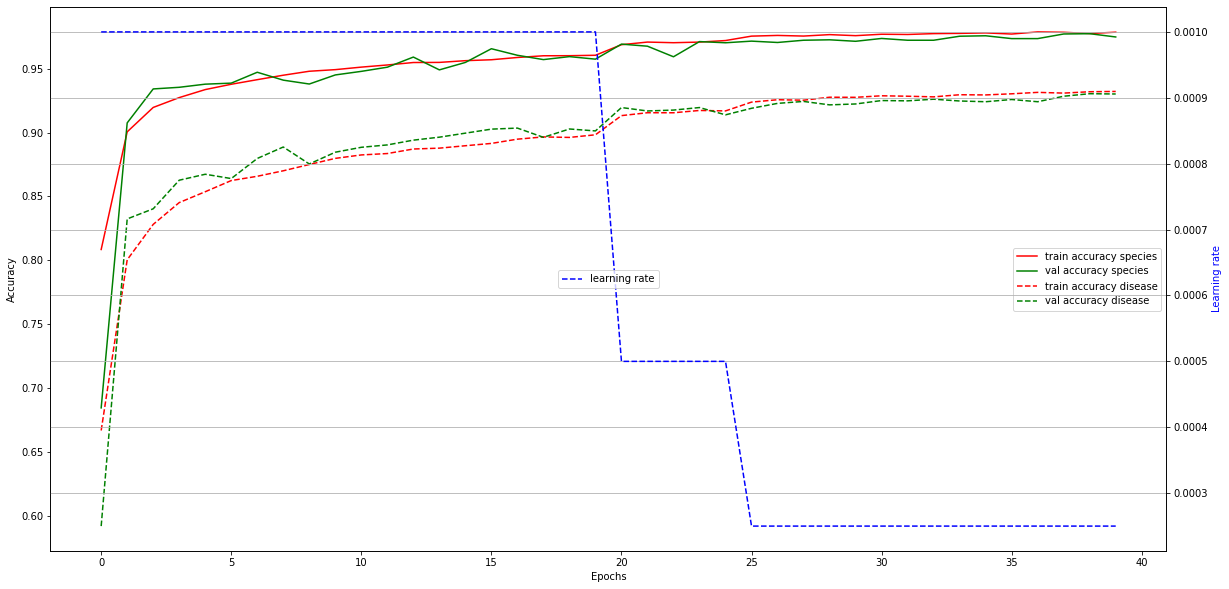

In [ ]:
#Affichage des données d'entrainement du modèle VGG16
#history = model


fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot(history.history['species_output_accuracy'], label='train accuracy species', color='red')
ax1.plot(history.history['val_species_output_accuracy'], label='val accuracy species', color='green')
ax1.plot(history.history['disease_output_accuracy'],'--', label='train accuracy disease', color='red')
ax1.plot(history.history['val_disease_output_accuracy'],'--', label='val accuracy disease', color='green')
ax2.plot(history.history['lr'], '--', label='learning rate', color='blue')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='k')
ax2.set_ylabel('Learning rate', color='b')

ax1.legend(loc='center right')
ax2.legend(loc='center')
plt.grid(True)
plt.show()


##Chargement du modèle

In [ ]:


# model = load_model(save_folder+'/modele')
# model.save(save_folder)
model = load_model(save_folder)

#chargement des indices de train, valid et test
train_indices = np.loadtxt(save_folder+'/'+'train.csv').astype(int)
valid_indices = np.loadtxt(save_folder+'/'+'valid.csv',).astype(int)
test_indices = np.loadtxt(save_folder+'/'+'test.csv').astype(int)



In [ ]:
test_data = data_generator.get_images([test_indices[0]],sans_fond=True)

In [ ]:
test_img=data_generator.get_images([0],sans_fond=True)

In [ ]:
save_folder

'/gdrive/MyDrive/epyphyte/entrainement/modeles/bisortie_modele_plantes_dependantes_231221_#3'



##Prédictions sur l'ensemble de test

In [ ]:
df_chemin_test=df_chemin_3
code_plante_pred=[]
code_plante_true=[]
code_maladie_pred=[]
code_maladie_true=[]

#pas terrible, les images de test sont chargées une par une.
# à voir plus tard si on peut les charger toutes d'un coup ou par batch pour
#réduire la boucle

for j,i in enumerate(test_indices):

  test = data_generator.get_images([i])

  # on repère l'echantillo, d'indice i
  plante_1_true = test[1][0]
  maladie_1_true = test[1][1]

  code_plante_true.append(test[1][0][0].argmax())
  code_maladie_true.append(test[1][1][0].argmax())

  plante_1hot,maladie_1hot = model.predict(test[0])
  code_plante_pred.append(plante_1hot.argmax(axis=1)[0])
  code_maladie_pred.append(maladie_1hot.argmax(axis=1)[0])

  # df_chemin_test.iloc[i]['code_plante_pred']=code_plante_pred
  # df_chemin_test.iloc[i]['code_maladie_pred']=code_maladie_pred

  if j%2000==0:
    print(len(test_indices)-j)








10862
8862
6862
4862
2862
862


In [ ]:
df_test=pd.DataFrame(code_plante_true)
df_test.columns=['code_plante_true']
df_test['code_maladie_true']=pd.Series(code_maladie_true)
df_test['code_plante_pred']=pd.Series(code_plante_pred)
df_test['code_maladie_pred']=pd.Series(code_maladie_pred)
df_old=df_test
df_test['code_plante_true'] = df_test['code_plante_true'].apply(lambda x : reversed_classes_plantes[x])
df_test['code_plante_pred'] = df_test['code_plante_pred'].apply(lambda x : reversed_classes_plantes[x])
df_test['code_maladie_true'] = df_test['code_maladie_true'].apply(lambda x : reversed_classes_maladies[x])
df_test['code_maladie_pred'] = df_test['code_maladie_pred'].apply(lambda x : reversed_classes_maladies[x])

In [ ]:
from sklearn.metrics import accuracy_score
# matrice de confusion plante 
cm = pd.crosstab(df_test['code_plante_true'],df_test['code_plante_pred'])
print('Accuracy plante = ',accuracy_score(code_plante_true,code_plante_pred))
cm

Accuracy plante =  0.9751426993187259


code_plante_pred,Apple,Blueberry,Cherry_(including_sour),Corn_(maize),Grape,Orange,Peach,"Pepper,_bell",Potato,Raspberry,Soybean,Squash,Strawberry,Tomato
code_plante_true,,,,,,,,,,,,,,
Apple,609,5,4,0,0,1,2,7,2,2,4,0,1,3
Blueberry,4,297,2,0,0,1,0,1,0,0,0,0,0,4
Cherry_(including_sour),1,1,416,0,0,1,1,2,0,0,0,0,0,1
Corn_(maize),0,0,0,779,0,0,0,0,0,0,0,0,0,3
Grape,0,0,0,0,792,0,0,0,0,1,0,3,0,2
Orange,4,2,2,1,0,1010,3,8,0,0,5,0,0,8
Peach,6,3,4,0,0,0,520,4,0,0,1,0,0,1
"Pepper,_bell",1,4,0,0,0,1,1,480,0,0,0,0,1,7
Potato,2,1,0,0,1,0,0,2,418,3,1,0,2,13


In [ ]:
# matrice de confusion maladie 
cm = pd.crosstab(df_test['code_maladie_true'],df_test['code_maladie_pred'])
print('Accuracy maladie = ',accuracy_score(code_maladie_true,code_maladie_pred))

cm

Accuracy maladie =  0.9278217639477077


code_maladie_pred,Apple_scab,Bacterial_spot,Black_rot,Cedar_apple_rust,Cercospora_leaf_spot Gray_leaf_spot,Common_rust_,Early_blight,Esca_(Black_Measles),Haunglongbing_(Citrus_greening),Late_blight,Leaf_Mold,Leaf_blight_(Isariopsis_Leaf_Spot),Leaf_scorch,Northern_Leaf_Blight,Powdery_mildew,Septoria_leaf_spot,Spider_mites Two-spotted_spider_mite,Target_Spot,Tomato_Yellow_Leaf_Curl_Virus,Tomato_mosaic_virus,healthy
code_maladie_true,,,,,,,,,,,,,,,,,,,,,
Apple_scab,125,1,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,3
Bacterial_spot,2,977,4,1,0,0,10,0,1,13,5,0,0,0,3,26,1,11,7,2,22
Black_rot,0,2,335,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,0,1,4
Cedar_apple_rust,2,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cercospora_leaf_spot Gray_leaf_spot,0,0,0,0,101,0,0,0,0,0,1,0,0,10,0,0,0,0,0,0,0
Common_rust_,0,0,0,0,3,214,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0
Early_blight,3,18,2,0,0,0,321,0,0,27,3,0,2,0,0,7,3,13,0,2,3
Esca_(Black_Measles),0,0,20,0,0,0,0,271,0,0,0,0,0,0,0,0,0,0,0,0,0
Haunglongbing_(Citrus_greening),0,4,1,0,0,0,1,0,998,1,1,0,0,0,4,0,0,0,2,0,31


In [ ]:
# affichage des pĥotos mal classées plante
faux_plante=[]
faux_maladie=[]
faux_pour_un = []
faux_tout=[]

for i in range(len(df_old)):



  if not (df_old.iloc[i].code_plante_true == df_old.iloc[i].code_plante_pred):
    faux_plante.append(i)

  if not (df_old.iloc[i].code_maladie_true ==  df_old.iloc[i].code_maladie_pred):
    faux_maladie.append(i)

  if not ((df_old.iloc[i].code_plante_true ==  df_old.iloc[i].code_plante_pred) & (df_old.iloc[i].code_maladie_true ==  df_old.iloc[i].code_maladie_pred)):
    faux_pour_un.append(i)

  if not ((df_old.iloc[i].code_plante_true ==  df_old.iloc[i].code_plante_pred) | (df_old.iloc[i].code_maladie_true ==  df_old.iloc[i].code_maladie_pred)):
    faux_tout.append(i)

print('Mauvais classement plante #=',len(faux_plante))
print('Mauvais classement maladie #=',len(faux_maladie))
print('Mauvais classement plante ou maladie #=',len(faux_pour_un))
print('Mauvais classement plante et maladie #=',len(faux_tout))


Mauvais classement plante #= 270
Mauvais classement maladie #= 784
Mauvais classement plante ou maladie #= 947
Mauvais classement plante et maladie #= 107


In [ ]:
def affiche_images(test_img,indices):

  N=len(test_img[0])
  Nlignes = N//3 + 1

  

  for j,i in enumerate(indices):
    

    plt.figure(figsize=(10,10))
    
    #plt.subplot(Nlignes,3,j+1)

   
    img=test_img[0][j]
    mini=img.min()
    maxi=img.max()


    img=(test_img[0][j]-mini)/(maxi-mini)
    plt.imshow(img)

    #num_classe_reelle = str(df_old.iloc[i]['code_plante_true'])+','+str(df_old.iloc[i]['code_maladie_true'])
    #num_classe_pred = str(df_old.iloc[i]['code_plante_pred'])+','+str(df_old.iloc[i]['code_maladie_pred'])
    nom_classe_reelle = df_test.iloc[i]['code_plante_true']+','+df_test.iloc[i]['code_maladie_true']
    nom_classe_pred = df_test.iloc[i]['code_plante_pred']+','+df_test.iloc[i]['code_maladie_pred']

    plt.axis('off')
    plt.title('R : '+nom_classe_reelle + '\n ' + 'P : '+ nom_classe_pred)



In [ ]:
test_img=data_generator.get_images(faux_plante,sans_fond=True)
#affiche_images(test,faux_plante)
affiche_images(test_img,faux_plante)

In [ ]:
test_img=data_generator.get_images(faux_tout,sans_fond=True)
#affiche_images(test,faux_plante)
affiche_images(test_img,faux_tout)

## Prédictions sur images réelles

## Prédiction sur images réelles avec suppression du fond

In [ ]:
# Clone the repository, and download the pre-trained model

import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for video matting
pretrained_ckpt = 'pretrained/modnet_webcam_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1Nf1ZxeJZJL8Qx9KadcYYyEmmlKhTADxX \
          -O pretrained/modnet_webcam_portrait_matting.ckpt

/content
Cloning into 'MODNet'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 249 (delta 21), reused 24 (delta 9), pack-reused 206
Receiving objects: 100% (249/249), 60.76 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/MODNet
Downloading...
From: https://drive.google.com/uc?id=1Nf1ZxeJZJL8Qx9KadcYYyEmmlKhTADxX
To: /content/MODNet/pretrained/modnet_webcam_portrait_matting.ckpt
100% 26.3M/26.3M [00:00<00:00, 72.0MB/s]


In [ ]:
#import io
import PIL
#import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from src.models.modnet import MODNet


modnet = MODNet(backbone_pretrained=False)
modnet = nn.DataParallel(modnet).cuda()
modnet.load_state_dict(torch.load(pretrained_ckpt))
modnet.eval()


torch_transforms = transforms.Compose(
  [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ]
)


def modnet_matting(modnet, im_frame):
  im_PIL = PIL.Image.open(im_frame)
  im_PIL = im_PIL.resize((640,480), PIL.Image.ANTIALIAS)
  im_np = np.asarray(im_PIL)

  im_tensor = torch_transforms(im_PIL)
  im_tensor = im_tensor[None, :, :, :].cuda()
  
  _, _, matte_tensor = modnet(im_tensor, True)
  matte_tensor = matte_tensor.repeat(1, 3, 1, 1)
  matte_np = matte_tensor[0].data.cpu().numpy().transpose(1, 2, 0)
  fg_np = matte_np * im_np + (1 - matte_np) * np.full(im_np.shape, 255.0)

  fg_np = np.float32(fg_np)

  return fg_np


In [ ]:


chemin_images_reelles = 'images_reelles'
emplacement_src_gdrive = '/gdrive/MyDrive/epyphyte/donnees/test'

import shutil
#if  not os.path.isdir('chemin_images_relles'):
shutil.copytree(emplacement_src_gdrive,chemin_images_reelles)

df_chemin_test=repertoire_test_to_df(chemin_images_reelles)
df_chemin_test.head()


df_chemin_test['code_plante']=df_chemin_test['plante'].apply(lambda x : CLASSES_plantes[x])
df_chemin_test['code_maladie']=df_chemin_test['maladie'].apply(lambda x : CLASSES_maladies[x])
data_gen_reel = DataGenerator(df_chemin_test)


FileExistsError: ignored

In [ ]:
df_chemin_test['code_plante']=df_chemin_test['plante'].apply(lambda x : CLASSES_plantes[x])
df_chemin_test['code_maladie']=df_chemin_test['maladie'].apply(lambda x : CLASSES_maladies[x])
data_gen_reel = DataGenerator(df_chemin_test)

code_plante_pred=[]
code_plante_true=[]
code_maladie_pred=[]
code_maladie_true=[]

#pas terrible, les images de test sont chargées une par une.
# à voir plus tard si on peut les charger toutes d'un coup ou par batch pour
#réduire la boucle

for i in range(len(df_chemin_test)):

  test = data_gen_reel.get_images([i],sans_fond=True)

  # on repère l'echantillo, d'indice i
  plante_1_true = test[1][0]
  maladie_1_true = test[1][1]

  code_plante_true.append(test[1][0][0].argmax())
  code_maladie_true.append(test[1][1][0].argmax())

  x = modnet_matting(modnet, df_chemin_test.iloc[i]['chemin_segmented']) # chargement de l'image et suppression du fond
    
  x = np.where(x >= 245, 0, x) # remplacement du fond blanc par un fond noir

  x = cv2.resize(x, dsize=(largeur,hauteur), interpolation = cv2.INTER_AREA)

  img = np.uint8(x)

  x = np.expand_dims(x, axis=0) # shape = (1, 224, 224, 3)
  x = preprocess_input(x)
  test[0][0]=x

  plante_1hot,maladie_1hot = model.predict(test[0])
  code_plante_pred.append(plante_1hot.argmax(axis=1)[0])
  code_maladie_pred.append(maladie_1hot.argmax(axis=1)[0])

  # df_chemin_test.iloc[i]['code_plante_pred']=code_plante_pred
  # df_chemin_test.iloc[i]['code_maladie_pred']=code_maladie_pred









/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
df_test=pd.DataFrame(code_plante_true)
df_test.columns=['code_plante_true']
df_test['code_maladie_true']=pd.Series(code_maladie_true)
df_test['code_plante_pred']=pd.Series(code_plante_pred)
df_test['code_maladie_pred']=pd.Series(code_maladie_pred)
df_old=df_test
df_test['code_plante_true'] = df_test['code_plante_true'].apply(lambda x : reversed_classes_plantes[x])
df_test['code_plante_pred'] = df_test['code_plante_pred'].apply(lambda x : reversed_classes_plantes[x])
df_test['code_maladie_true'] = df_test['code_maladie_true'].apply(lambda x : reversed_classes_maladies[x])
df_test['code_maladie_pred'] = df_test['code_maladie_pred'].apply(lambda x : reversed_classes_maladies[x])

In [ ]:
from sklearn.metrics import accuracy_score
# matrice de confusion plante 
cm = pd.crosstab(df_test['code_plante_true'],df_test['code_plante_pred'])
print('Accuracy plante = ',accuracy_score(code_plante_true,code_plante_pred))
cm

Accuracy plante =  0.3018867924528302


code_plante_pred,Apple,Grape,Peach,"Pepper,_bell",Squash,Strawberry,Tomato
code_plante_true,,,,,,,
Apple,1,2,1,1,0,1,1
Grape,0,1,0,4,0,1,1
Potato,0,1,0,0,0,1,2
Squash,0,3,0,0,1,0,5
Tomato,4,4,2,1,1,1,13


In [ ]:
# matrice de confusion maladie 
cm = pd.crosstab(df_test['code_maladie_true'],df_test['code_maladie_pred'])
print('Accuracy maladie = ',accuracy_score(code_maladie_true,code_maladie_pred))

cm

Accuracy maladie =  0.09433962264150944


code_maladie_pred,Bacterial_spot,Black_rot,Early_blight,Esca_(Black_Measles),Late_blight,Leaf_blight_(Isariopsis_Leaf_Spot),Leaf_scorch,Powdery_mildew,Septoria_leaf_spot,Tomato_Yellow_Leaf_Curl_Virus
code_maladie_true,,,,,,,,,,
Apple_scab,1,4,0,0,0,0,2,0,0,0
Bacterial_spot,1,3,0,0,0,0,0,0,1,1
Black_rot,3,2,0,0,0,0,1,0,1,0
Early_blight,3,3,1,0,0,1,1,2,2,1
Late_blight,0,0,1,1,0,1,1,0,0,0
Leaf_Mold,0,2,0,0,1,0,0,1,0,2
Powdery_mildew,1,0,1,2,2,0,1,1,1,0


In [ ]:
test_img=data_gen_reel.get_images(np.arange(0,len(df_chemin_test)),sans_fond=True)
#affiche_images(test,faux_plante)
affiche_images(test_img,np.arange(0,len(df_chemin_test)))

Output hidden; open in https://colab.research.google.com to view.